In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
from plotting_funcs import *
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [109]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-3]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [110]:
all_X.condition.unique()

array(['50', '37', '25'], dtype=object)

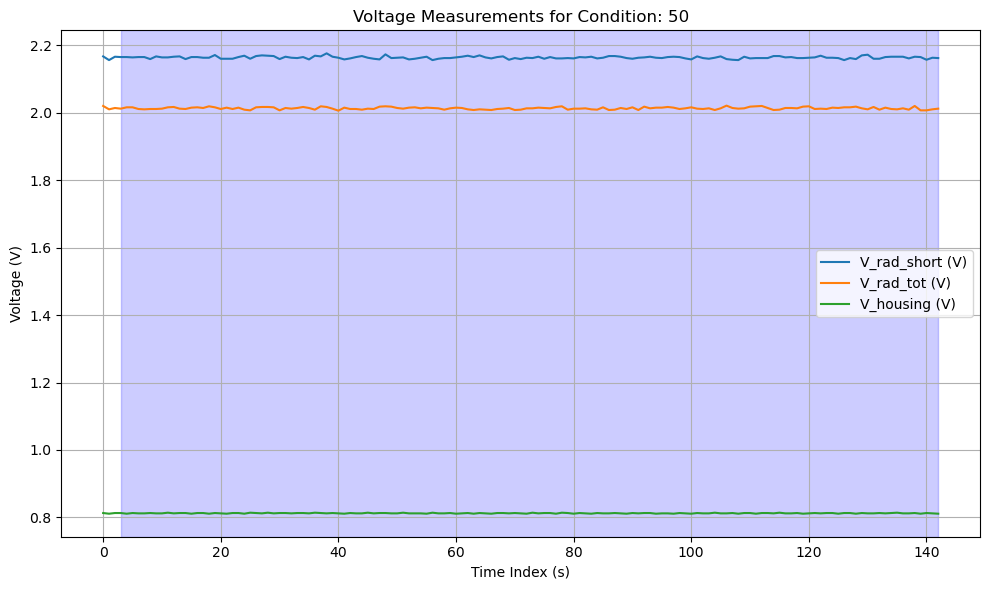

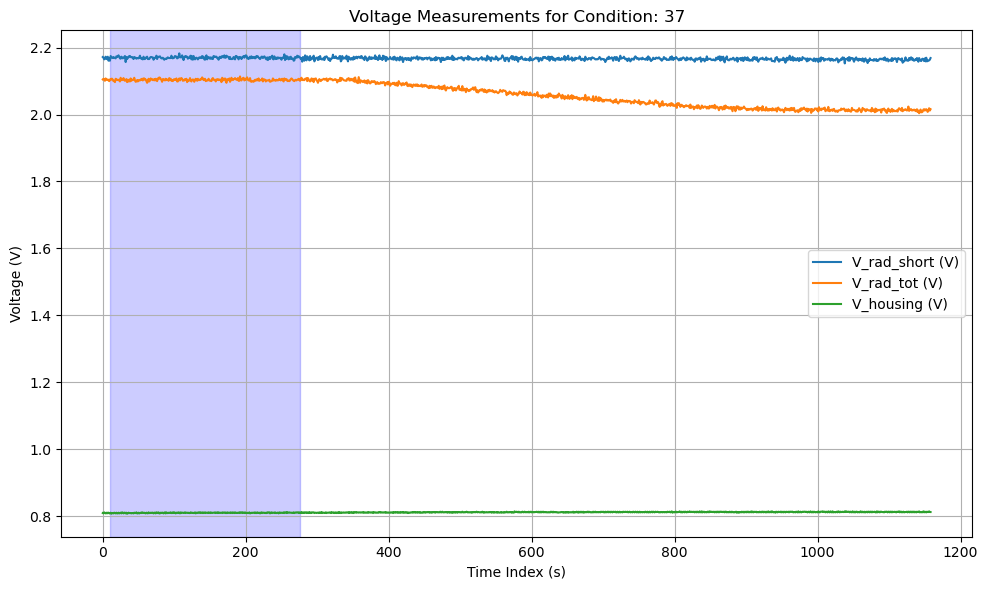

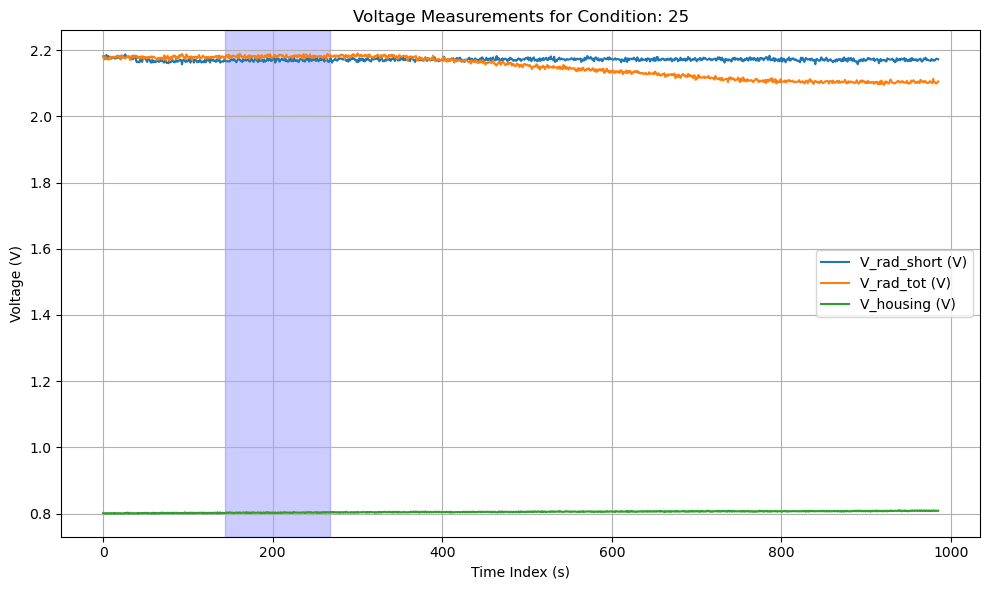

In [111]:
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        # Group consecutive periods
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            plt.axvspan(start, end, color='blue', alpha=0.2)
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [112]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = ["bias"]
    labels_37 = ["bias"]
    labels_50 = ["bias"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "37":
        cond_labels = labels_37 * ((len(periods) + len(labels_37) - 1) // len(labels_37))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 50
class
bias    140
None      3
Name: count, dtype: int64

Condition: 37
class
None    892
bias    267
Name: count, dtype: int64

Condition: 25
class
None    861
bias    125
Name: count, dtype: int64


In [113]:
# Get indices of rows with 'bias' class for condition '37'
bias_mask = (all_X['condition'] == '37') & (all_X['class'] == 'bias')
bias_indices = all_X[bias_mask].index

n_total_bias = len(bias_indices)
n_select = 140
start_idx = bias_indices[int((n_total_bias - n_select) // 2)]
end_idx = bias_indices[int((n_total_bias + n_select) // 2) - 1]

# Set all to None first, then assign 'bias' to the middle 140
all_X.loc[bias_indices, 'class'] = None
all_X.loc[start_idx:end_idx, 'class'] = 'bias'


In [114]:

# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
for cond in all_X_clean['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 50
class
bias    140
Name: count, dtype: int64

Condition: 37
class
bias    140
Name: count, dtype: int64

Condition: 25
class
bias    125
Name: count, dtype: int64


In [115]:
all_X_clean = all_X_clean.rename(columns={"class": "condition", "condition":"class"})


Condition bias - Data summary by class:
  25: 125 points, time range: 0.0 - 124.0 s
  37: 140 points, time range: 145.0 - 284.0 s
  50: 140 points, time range: 305.0 - 444.0 s


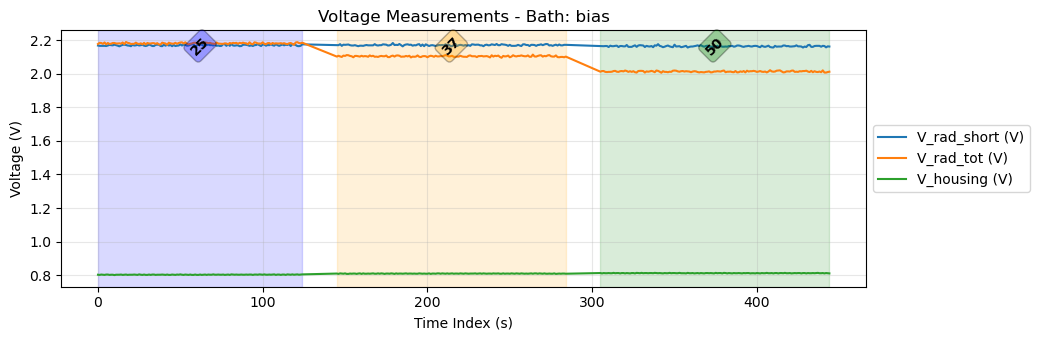

In [116]:
class_order = ["25", "37", "50"]
class_colors = {
    "25": "blue",
    "37": "orange",
    "50": "green"
}
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1000,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

In [117]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_rad_short', 'V_housing']].mean()

    print("Microvolts:")
    print(avg_voltages.round(1))
    print("-" * 30)

Average voltages by condition and class:

Condition: bias
Microvolts:
       V_rad_tot  V_rad_short  V_housing
class                                   
25        2180.8       2169.6      803.3
37        2104.1       2170.5      809.8
50        2013.1       2163.6      812.4
------------------------------


In [118]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

T_cable = 25  # °C

In [119]:
vna_excel_path = Path("/Users/mcy/Library/CloudStorage/OneDrive-HEPTAMEDICAL/HEPTA ADMIN - presentation_Manuel/VNA/VNA Measurements.xlsx")
vna_data = pd.read_excel(vna_excel_path)

date = "Aug 27 2025"
tau_cable = vna_data[(vna_data['DUT'] == 'Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer = vna_data[(vna_data['DUT'] == 'Diplexer') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector = vna_data[(vna_data['DUT'] == 'Diplexer + Connector') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diplexer_connector_cable = vna_data[(vna_data['DUT'] == 'Diplexer + Connector + Cable') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_off = vna_data[(vna_data['DUT'] == 'Diode (no bias)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_positive = vna_data[(vna_data['DUT'] == 'Diode (bias positive)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]
tau_diode_bias_negative = vna_data[(vna_data['DUT'] == 'Diode (bias negative)') & (vna_data["Date"] == date)]['S21 (power)'].values[0]

print(f"Cable transmission: {tau_cable:.3f}")
print(f"Diplexer transmission: {tau_diplexer:.3f}")
print(f"Diplexer + Connector transmission: {tau_diplexer_connector:.3f}")
print(f"Diplexer + Connector + Cable transmission: {tau_diplexer_connector_cable:.3f}")
print(f"Diode (no bias) transmission: {tau_diode_bias_off:.3f}")
print(f"Diode (bias positive) transmission: {tau_diode_bias_positive:.3f}")
print(f"Diode (bias negative) transmission: {tau_diode_bias_negative:.3f}")

Cable transmission: 0.589
Diplexer transmission: 0.953
Diplexer + Connector transmission: 0.905
Diplexer + Connector + Cable transmission: 0.535
Diode (no bias) transmission: 0.845
Diode (bias positive) transmission: 0.003
Diode (bias negative) transmission: 0.849


In [120]:
T_cable = 25
tau_diplexer_derived = 0.6774
tau_total = tau_diode_bias_negative * tau_cable / 0.95 * tau_diplexer_derived
print(f"Total transmission: {tau_total:.3f}")

Total transmission: 0.357


In [121]:
print(class_order)
conditions = ["bias"]
for cond in conditions:
    print(cond, all_X_clean[all_X_clean['condition'] == cond]['class'].unique())

['25', '37', '50']
bias ['50' '37' '25']


In [122]:
for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_rad_short = class_data['V_rad_short'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
        T_short = T_rad_func(V_rad_short, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
        T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_total)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_short'] = T_short
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue



Condition bias - Data summary by class:
  25: 125 points, time range: 0.0 - 124.0 s
  37: 140 points, time range: 145.0 - 284.0 s
  50: 140 points, time range: 305.0 - 444.0 s


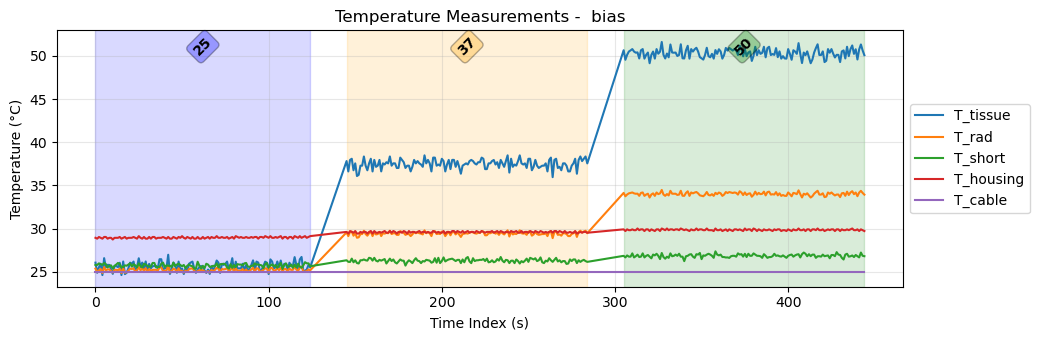

In [123]:
variables = ['T_tissue', 'T_rad', 'T_short', 'T_housing', 'T_cable']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements -  ",
    ylabel="Temperature (°C)"
)

In [124]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[variables].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: bias
Microvolts:
       T_tissue  T_rad  T_short  T_housing  T_cable
class                                              
25         25.6   25.2     25.8       29.0     25.0
37         37.5   29.5     26.3       29.6     25.0
50         50.3   34.0     26.9       29.9     25.0
------------------------------


## Calculate CL for the Diode Switch 

$$
\tau_{\text{cable}} = (1 - CL)
$$

$$
T_{\text{end\_of\_cable}} = T_{\text{rad}}\cdot \tau_{\text{cable}} + T_{\text{cable}}\cdot (1 - \tau_{\text{cable}})
$$

$$ 
T_{\text{short}} = T_{\text{end\_of\_cable}} \cdot \tau_{\text{cable}} + T_{\text{cable}}\cdot (1 - \tau_{\text{cable}})
$$

$$
T_{\text{short}} = T_{\text{rad}}\cdot \tau_{\text{cable}}^2 + T_{\text{cable}}\cdot (1 - \tau_{\text{cable}}^2) 
$$

Solve for $\tau_{\text{cable}}$:

$$
\tau_{\text{cable}} = \pm \sqrt{\frac{T_{\text{short}} - T_{\text{cable}}}{T_{\text{rad}} - T_{\text{cable}}}}
$$

**Condition for real solutions:**

$$
\quad \frac{T_{\text{short}} - T_{\text{cable}}}{T_{\text{rad}} - T_{\text{cable}}} \ge 0
$$


In [125]:
def CL_has_real_solution(T_short, T_housing, T_cable):
    """
    Returns True if the condition for real solution is satisfied:
    (T_short - T_cable) / (T_housing - T_cable) >= 0
    Accepts scalar or numpy array inputs.
    """
    return (T_short - T_cable) / (T_housing - T_cable) >= 0

def compute_CL(T_short, T_housing, T_cable):
    """
    Computes Cable Loss (CL) from T_short, T_housing, T_cable.
    Uses the quadratic solution for tau_cable, then CL = 1 - tau_cable.
    Returns CL (scalar or array).
    """
    ratio = (T_short - T_cable) / (T_housing - T_cable)
    if np.any(ratio < 0):
        raise ValueError("No real solution for the given temperatures.")
    tau_cable_1 = np.sqrt(ratio)
    tau_cable_2 = -np.sqrt(ratio)
    CL_1 = 1 - tau_cable_1
    CL_2 = 1 - tau_cable_2
    return CL_1, CL_2

# Test CL_has_real_solution with average values for "25"
T_short_avg = avg_temperatures.loc['25', 'T_short']
T_rad_avg = avg_temperatures.loc['25', 'T_rad']
T_housing_avg = avg_temperatures.loc['25', 'T_housing']
T_cable_avg = T_cable

result = CL_has_real_solution(T_short_avg, T_housing_avg, T_cable_avg)
print(f"CL has real solution (25): {result}")

CL_value_1, CL_value_2 = compute_CL(T_short_avg, T_housing_avg, T_cable_avg)
print(f"Computed Cable Loss (CL) for 25: {CL_value_1:.4f}, {CL_value_2:.4f}")


CL has real solution (25): True
Computed Cable Loss (CL) for 25: 0.5646, 1.4354


In [126]:
print(loss_diplexer_connector_cable)

0.46457332990176003


In [127]:
# Check if computed CL values reconstruct T_short using the formula:
# T_short = T_rad * tau_cable**2 + T_cable * (1 - tau_cable)**2
# where tau_cable = 1 - CL

T_rad_val = T_rad_avg
T_cable_val = T_cable_avg
T_short_val = T_short_avg

tau_cable_1 = 1 - CL_value_1
tau_cable_2 = 1 - CL_value_2

T_short_calc_1 = T_rad_val * tau_cable_1**2 + T_cable_val * (1 - tau_cable_1**2)
T_short_calc_2 = T_rad_val * tau_cable_2**2 + T_cable_val * (1 - tau_cable_2**2)

print(f"Original T_short: {T_short_val:.6f}")
print(f"Reconstructed T_short (CL_value_1): {T_short_calc_1:.6f}")
print(f"Reconstructed T_short (CL_value_2): {T_short_calc_2:.6f}")
print(f"Difference (CL_value_1): {T_short_val - T_short_calc_1:.6e}")
print(f"Difference (CL_value_2): {T_short_val - T_short_calc_2:.6e}")

Original T_short: 25.752927
Reconstructed T_short (CL_value_1): 25.043059
Reconstructed T_short (CL_value_2): 25.043059
Difference (CL_value_1): 7.098684e-01
Difference (CL_value_2): 7.098684e-01


In [128]:
print(T_rad_avg, T_short_avg, T_cable_avg)

25.22712554789918 25.752926910869345 25


## Canculate $\tau$ and T_cable at the same time

**If we do not know T_cable:**

The equation becomes more difficult but we can use for example the hot bath measruement:

Rename the two unknowns ($T_{\text{cable}} = T $ and $\tau_{\text{cable}} = \tau$)

$$
T_{\text{rad}} = T_{\text{bath}} \cdot \tau+ T \cdot (1-\tau)
$$

Solve for T:

$$
T = \frac{T_{\text{rad}} - T_{\text{bath}} \cdot \tau}{1 - \tau}
$$

$$
T_{\text{short}} = T_{\text{hous}}\cdot \tau^2 + \frac{T_{\text{rad}} - T_{\text{bath}} \cdot \tau}{1 - \tau}\cdot (1 - \tau^2) \\
= T_{\text{hous}}\cdot \tau^2 + (T_{\text{rad}} - T_{\text{bath}} \cdot \tau) \cdot (1 + \tau) \\ 
$$

$$
(T_{\text{bath}} - T_{\text{hous}})\tau^2 + 
(T_{\text{bath}} - T_{\text{rad}})\tau + 
(T_{\text{short}} - T_{\text{rad}})
= 0
$$

Solve for $\tau$:

$$
\tau = \frac{-(T_{\text{bath}} - T_{\text{rad}}) \pm \sqrt{(T_{\text{bath}} - T_{\text{rad}})^2 - 4 (T_{\text{bath}} - T_{\text{hous}})(T_{\text{short}} - T_{\text{rad}})}}{2 (T_{\text{bath}} - T_{\text{hous}})}
$$

In [95]:
from calibration_funcs import solve_tau_and_Tcable_v2

In [105]:
# Use the quadratic equation from markdown cell 20 to solve for tau (1-CL) and T_cable

result_taus = {}

for bath_temp in ['25', '37', '50']:
    T_rad_avg = avg_temperatures.loc[str(bath_temp), 'T_rad']
    T_short_avg = avg_temperatures.loc[str(bath_temp), 'T_short']
    T_housing_avg = avg_temperatures.loc[str(bath_temp), 'T_housing']
    T_bath = int(bath_temp)

    print(f"Quadratic solution for bath {bath_temp}°C:")
    results = solve_tau_and_Tcable_v2(T_rad_avg, T_short_avg, T_housing_avg, T_bath, 25, 0.85)[0]
    print(f"tau_cable = {results['tau_T']:.4f},  T_cable = {results['T_cable']:.2f} °C")
    print("-" * 50)
    result_taus[bath_temp] = results


Quadratic solution for bath 25°C:
tau_cable = 0.3177,  T_cable = 25.39 °C
--------------------------------------------------
Quadratic solution for bath 37°C:
tau_cable = 0.4036,  T_cable = 25.66 °C
--------------------------------------------------
Quadratic solution for bath 50°C:
tau_cable = 0.3926,  T_cable = 26.33 °C
--------------------------------------------------


In [106]:
import pandas as pd

# Theoretical values
theoretical_tau = 0.357
theoretical_T_cable = 25


tau_25 = result_taus['25']['tau_T']
tau_37 = result_taus['37']['tau_T']
tau_50 = result_taus['50']['tau_T']

T_cable_25 = result_taus['25']['T_cable']
T_cable_37 = result_taus['37']['T_cable']
T_cable_50 = result_taus['50']['T_cable']

# Calculate percentage differences
def percent_diff(derived, theoretical):
    return 100 * (derived - theoretical) / theoretical

table = pd.DataFrame({
    'tau_cable': [
        theoretical_tau,
        tau_25,
        tau_37,
        tau_50
    ],
    'tau_diff (%)': [
        0,
        percent_diff(tau_25, theoretical_tau),
        percent_diff(tau_37, theoretical_tau),
        percent_diff(tau_50, theoretical_tau)
    ],
    'T_cable': [
        theoretical_T_cable,
        T_cable_25,
        T_cable_37,
        T_cable_50
    ],
    'T_cable_diff (%)': [
        0,
        percent_diff(T_cable_25, theoretical_T_cable),
        percent_diff(T_cable_37, theoretical_T_cable),
        percent_diff(T_cable_50, theoretical_T_cable)
    ]
}, index=['Theoretical', 'Derived @ 25°C', 'Derived @ 37°C', 'Derived @ 50°C'])

print(table.round(4))

                tau_cable  tau_diff (%)  T_cable  T_cable_diff (%)
Theoretical        0.3570        0.0000  25.0000            0.0000
Derived @ 25°C     0.3177      -11.0116  25.3916            1.5665
Derived @ 37°C     0.4036       13.0424  25.6616            2.6464
Derived @ 50°C     0.3926        9.9653  26.3258            5.3033


| Case             | tau_total | tau_diff (%) | T_total | T_total_diff (%) |
|------------------|-----------|--------------|---------|------------------|
| Experimental      | 0.3570    | 0.0000       | 25.0000 | 0.0000           |
| Derived @ 25°C   | 0.3364    | -5.7745      | 25.3423 | 1.3690           |
| Derived @ 37°C   | 0.3180    | -10.9380     | 25.9329 | 3.7318           |
| Derived @ 50°C   | 0.3194    | -10.5368     | 26.5312 | 6.1249           |


In [64]:
# Use tau_cable_1 and T_cable_1 from 'results' to reconstruct T_rad and T_short
tau = results['tau_cable_1']
T_cable_1 = results['T_cable_1']
T_bath = 50
T_housing_avg = avg_temperatures.loc['bias on', 'T_housing']

# Reconstruct T_rad using: T_rad = T_bath * tau + T_cable_1 * (1 - tau)
T_rad_reconstructed = T_bath * tau + T_cable_1 * (1 - tau)

# Reconstruct T_short using:
# T_short = T_housing_avg * tau**2 + T_cable_1 * (1 - tau**2)
T_short_reconstructed = T_housing_avg * tau**2 + T_cable_1 * (1 - tau**2)

print(f"Measured T_rad: {avg_temperatures.loc['bias on', 'T_rad']:.4f}")
print(f"Reconstructed T_rad: {T_rad_reconstructed:.4f}")
print(f"Difference: {avg_temperatures.loc['bias on', 'T_rad'] - T_rad_reconstructed:.4e}")

print(f"Measured T_short: {avg_temperatures.loc['bias on', 'T_short']:.4f}")
print(f"Reconstructed T_short: {T_short_reconstructed:.4f}")
print(f"Difference: {avg_temperatures.loc['bias on', 'T_short'] - T_short_reconstructed:.4e}")

Measured T_rad: 34.6801
Reconstructed T_rad: 34.6801
Difference: 0.0000e+00
Measured T_short: 27.8786
Reconstructed T_short: 27.8786
Difference: 0.0000e+00


## Determining T_cable and Cable Loss from the data

In [33]:
avg_T_rad_25 = all_X_clean[(all_X_clean['condition'] == '25') & (all_X_clean['class'] == 'cable+load')]['T_rad'].mean()
avg_T_rad_50 = all_X_clean[(all_X_clean['condition'] == '50') & (all_X_clean['class'] == 'cable+load')]['T_rad'].mean()

print(f"Average T_rad for condition 25, class cable+load: {avg_T_rad_25:.2f} °C")
print(f"Average T_rad for condition 50, class cable+load: {avg_T_rad_50:.2f} °C")

Average T_rad for condition 25, class cable+load: 24.89 °C
Average T_rad for condition 50, class cable+load: 39.58 °C


In [34]:
T_bath_cold = 25
T_bath_hot = 50 
CL_empirical = - ((avg_T_rad_50 - avg_T_rad_25) - (T_bath_hot - T_bath_cold)) / (T_bath_hot - T_bath_cold)
print(f"Empirical Cable Loss (CL_empirical): {CL_empirical:.4f}")
print(f"Percentage change in Cable Loss: {((CL_empirical - CL) / CL * 100):.2f}%")

Empirical Cable Loss (CL_empirical): 0.4122
Percentage change in Cable Loss: -6.11%


In [36]:
Tcable_empirical = (avg_T_rad_50 - (1 - CL_empirical) * T_bath_hot) / CL_empirical
print(f"Empirical T_cable (Tcable_empirical): {Tcable_empirical:.2f} °C")
print(f"Percentage change in T_cable: {((Tcable_empirical - T_cable) / T_cable * 100):.2f}%")

Empirical T_cable (Tcable_empirical): 24.72 °C
Percentage change in T_cable: 0.91%


In [37]:
for cond in conditions:
    for class_name in ["load", "cable+load"]:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable+load":
            # T_cable = 23.7 if cond == "25" else 24.7
            # T_cable = 23.7 
            T_cable = Tcable_empirical
            T_tissue = T_tissue_cable_func(T_rad, T_cable, CL_empirical)
        elif class_name in ["load"]:
            T_cable = None
            T_tissue = T_rad
        
        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable


Condition 25 - Data summary by class:
  load: 132 points, time range: 0.0 - 131.0 s
  cable+load: 128 points, time range: 152.0 - 279.0 s

Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  cable+load: 123 points, time range: 144.0 - 266.0 s


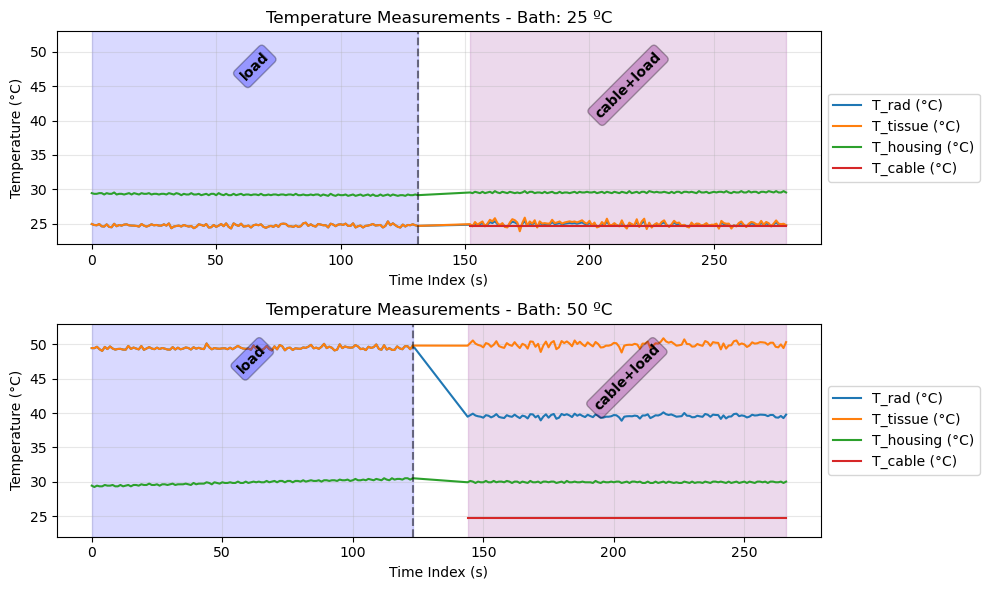

In [38]:
# Define class order and colors
class_order = ['load', 'cable+load']
class_colors = {
    'load': 'blue',
    'cable+load': 'purple',

}

# Define voltage variables to plot
variables = ['T_rad', 'T_tissue', 'T_housing', 'T_cable']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_rad': 'T_rad (°C)',
    'T_cable': 'T_cable (°C)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(5 * len(conditions), 6))
axes[0].set_ylim(22, 53)
axes[1].set_ylim(22, 53)
plt.ylim(22, 53)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add vertical line at the end of each class (except the last one)
            if class_name != available_classes[-1]:
                ax.axvline(class_end, color='black', linestyle='--', alpha=0.5)
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Temperature Measurements - Bath: {condition} ºC")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()

In [63]:
0.4 / 0.54

0.7407407407407407